# FREE-ENERGY PRINCIPLE (FEP) TUTORIAL 3

## Braitenberg vehicle under the Free Energy Principle (FEP)
### Active inference model to obtain attractor behaviours to light

**Author: Tommie van der Drift and [Pablo Lanillos](https://www.ru.nl/personen/lanillos-p/).** Donders Institute for Brain, Cognition and Behaviour. Radboud University. The Netherlands.

<font color='green'>**Difficulty: high**</font>

The code is largely based on the [code](https://github.com/mbaltieri/braitenberg_vehicles) written by Manuel Baltieri for the following article: Baltieri, Manuel, and Christopher L. Buckley. An active inference implementation of phototaxis. Proceedings of the European Conference on Artificial Life 14. Vol. 14. One Rogers Street, MIT Press, 2017

**Adapted for the course by:** Marius Marten Kästingschäfer and Pablo Lanillos


## Overview

In this example we will implement the Braitenberg vehicles using the Free-energy Principle.

1. Explanation of the problem and the model
2. Initializating the variables
3. Main part (compute light levels, update variables, compute the Negative Variational Free Energy bound)   
4. Visualizing results



## 1. Explanation of the problem and the model

We have a 2D world with agents (Braitenberg vehicles) and sources of light. In the original description of the Braitenberg vehilces the behaviour depends on how we connect the sensors and the motors. In this tutorial we are only going to use the inverted connection, which is described in the following figure:  

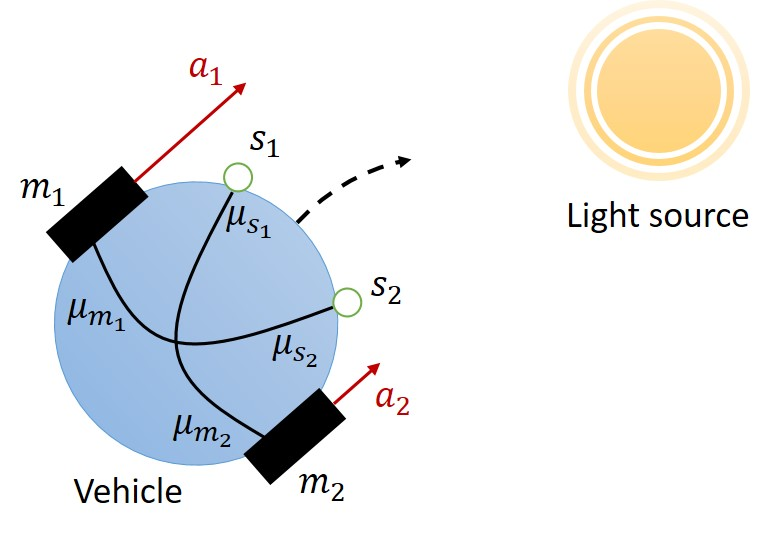

The sensory input in our case consist of the light intensity (exteroceptive) and the wheel velocity (Proprioceptive). The agent has two light sensors ($s_1, s_2$) and two motor sensors that provide the wheel velocity ($m_1,m_2$). The internal state of the agent is defined by the variables $\mu_{s_1}, \mu_{s_2}, \mu_{m_1}, \mu_{m_2}$, which define the belief of the agent about the environment (light) and the vehicle state (proprioception).

**Perception:** The internal state of the vehicle (unobserved variables) will be updated by optimizing the Variational Free Energy bound under the Laplace approximation.

**Action:** Action is another way of reducing the discrepancy between predictions of the generative model and sensations from the world. Thus, the velocities of the vehicle will be also generated by optimizing the Variational Free Energy bound under the Laplace approximation.

## 2. Initializating the variables

In [96]:
"""
Import libraries
"""

from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import numpy as np
from numpy.core._multiarray_umath import ndarray

In [97]:
"""
Agent variables
"""
dt_brain = .05
T_brain = 30
mean_speed = 200
min_hunger = 250
weight_bonus = 50
sensors_n = 2 # light sensors
motors_n = 2 # motors
obs_states = sensors_n
hidden_states = obs_states   
hidden_causes = sensors_n   

### Braitenberg vehicle variables
radius = 2 # vehile radious
length_dir = 3
l_max = 200.
turning_speed = 25. # radians/s
sensors_angle = np.pi / 3

"""
Environment variables
"""
dt = .005
T_world = T_brain / 10


## 3. Main part
## Compute light intensity from the light source

In [98]:
"""
Function computing the light level/intensity of the light percieved for a specific agent's location
input: x_agent (x y coordinates), light_sources (x y coordinates)
output: 1: the light intensity perceived (0-1)
        2: the speficic light source which is nearest, thus sourcing the 1st value
"""

def light_intensity(x_agent, light_sources):
    lightintensities = []
    # for every light_source the light intensity is computed
    for i in range(light_sources.shape[0]):
        sigma_x = 30.0
        sigma_y = 30.0
        Sigma = np.array([[sigma_x*sigma_x, 0.0], [0.0, sigma_y*sigma_y]])
        mu = [light_sources[i, 0], light_sources[i, 1]]
        corr = Sigma[0, 1] / (sigma_x * sigma_y)
        lightintensities.append(5655 * l_max / (2 * np.pi * sigma_x * sigma_y * np.sqrt(1 - corr ** 2)) * np.exp(
            - 1 / (2 * (1 - corr ** 2)) * ((x_agent[0] - mu[0]) ** 2 /
                                           (sigma_x ** 2) + (x_agent[1] - mu[1]) ** 2 / (sigma_y ** 2) -
                                           2 * corr * (x_agent[0] - mu[0]) * (x_agent[1] - mu[1]) / (
                                                   sigma_x * sigma_y))))

    return max(lightintensities), np.argmax(lightintensities)

## Action and observations

In [99]:
"""
the following function updates the following variables: v_motor, x_agent, theta and sensor.
x_agent and theta are global variables and do not have to be returned. Sensor holds the light level
of the agent as is created in this function, initialised and lastly returned.
"""

# return the new state of the agent depending on the action (velocity)
def action(x_agent, v_agent, v_motor, theta, a, i):
    v_motor[i, 0] = a[0] # action from the minimization of the VFE
    v_motor[i, 1] = a[1]

    # translation
    v_agent[i] = (v_motor[i, 0] + v_motor[i, 1]) / 2
    x_agent[i + 1, :] = x_agent[i, :] + dt * (v_agent[i] * np.array([np.cos(theta[i]), np.sin(theta[i])]))
    # rotation
    angle = turning_speed * np.float((v_motor[i, 1] - v_motor[i, 0]) / (2 * radius))
    theta[i + 1] = theta[i] + dt * angle
    theta[i + 1] = np.mod(theta[i + 1], 2 * np.pi)

    return v_motor[i, :]

# return light measurement for each sensor
def get_observations(x_agent, theta, z, i, light_sources):
    sensor = np.zeros(2, )
    x_agentCol = [[i] for i in x_agent[i, :]]
    sensor[0], _ = light_intensity(x_agentCol + radius * (
        np.array([[np.cos(theta[i] + sensors_angle)], [np.sin(theta[i] + sensors_angle)]])),
                                  light_sources)  # left sensor
    sensor[1], _  = light_intensity(x_agentCol + radius * (
        np.array([[np.cos(theta[i] - sensors_angle)], [np.sin(theta[i] - sensors_angle)]])),
                                  light_sources)  # right sensor
    return sensor, sensor + z

## Prediction errors
Just a refresh on how to compute the prediction errors. In the main function prediction errors are computed inline.

In [100]:
'''
Returns the error and the weighted error
'''
def sensory_errors(s, s_hat, log_precision):
    e_s = s - s_hat
    pi_s = np.exp(log_precision) * np.ones((obs_states,))
    w_e_s = pi_s * e_s
    return e_s, w_e_s


'''
Returns the error and the weighted error
'''
def dynamics_errors(mu, mu_hat, log_precision):
    e_d = mu - mu_hat
    pi_d = np.exp(log_precision) * np.ones((hidden_states,))
    w_e_d = pi_d * e_d
    return e_d, w_e_d

## Computing the Vartiational Free Energy
Under the Laplace approximation

In [101]:
def free_energy(e_s, e_s_m, e_d, log_var_s, log_var_s_m, log_var_d):
    w_e_s = log_var_s*e_s
    w_e_s_m = log_var_s_m*e_s_m
    w_e_d = log_var_d*e_d
    
    return .5 * (np.dot(e_s, np.transpose(w_e_s)) + np.dot(e_d, np.transpose(w_e_d)) + np.dot(e_s_m, np.transpose(w_e_s_m))) + np.log(np.prod(np.exp(log_var_s)) * np.prod(np.exp(log_var_s_m)) * np.prod(np.exp(log_var_d)))

## Braitenberg vehicle under the Free Energy

In [107]:
"""
Braitemberg vehicle main function.
Most variables are initialized here and updated for every iteration of the algorithm. The update function above is ran every
iteration too to display the progress of the agent. Please note that this code is scalable to multiple agents and hivesowever
for the purposes of this version, the agent_nr and hive_nr are set to one and can therefore be safely ignored. Whenever you see
a loop looping through either one of those variables you know that the block of code thereunder is only executed a single time.
"""

def braitenberg_free_energy(fig, ax, agent_nr = 1, light_nr = 1, update_gain = 1, iterations = 100):
    
    k = update_gain
    
    # Initialization of variables
    s = np.zeros((iterations, sensors_n, agent_nr))
    theta = np.zeros((iterations, agent_nr))                # orientation of the agent
    x_agent = np.zeros((iterations, 2, agent_nr))  # 2D world, 2 coordinates for agent position
    v_agent = np.zeros((iterations, agent_nr))
    v_motor = np.zeros((iterations, motors_n, agent_nr))

    # Free energy variables
    VFE = np.zeros((iterations-1, agent_nr)) # Variational negative free energy bound
    rho = np.zeros((iterations, obs_states, agent_nr)) # sensory inputs
    mu_x = np.zeros((iterations, hidden_states, agent_nr)) # inferred states
    mu_m = np.zeros((iterations, hidden_states, agent_nr)) # inferred states motor
    a = np.zeros((iterations, motors_n, agent_nr)) # action
    
    log_var_s = np.ones((sensors_n, agent_nr)) # log-precision on sensory input
    pi_s = np.ones((sensors_n, agent_nr)) # precision sensors
    real_pi_s = np.ones((sensors_n, agent_nr)) # real precision sensors
    sigma_z = np.ones((sensors_n, agent_nr))*0.1 # std sensors
    z = np.zeros((iterations, sensors_n, agent_nr)) # sensory noise
    log_var_s_m = np.ones((motors_n, agent_nr))  # log-precision on motor input
    pi_s_m = np.ones((motors_n, agent_nr)) # precision in motor input
    real_pi_s_m = np.exp(32) * np.ones((motors_n,)) # real precision in motor input
    z_m = np.zeros((iterations, motors_n, agent_nr)) # motors sensory noise
    sigma_z_m = 1 / (np.sqrt(real_pi_s_m)) # std motors
    log_var_d = np.ones((hidden_states, agent_nr)) # log-precision on dynamic errors
    pi_d_m = np.ones((hidden_states, agent_nr))
            

    # initializes the array holding the values for the light which is spawned randomnly througout the area
    light_sources = np.ones((light_nr, 2))
    for i in range(light_nr):
        light_sources[i, 0] = np.random.rand()*120.
        light_sources[i, 1] = np.random.rand()*120.

    # Initialisation 
    for j in range(agent_nr):
            # initialisation the agent position and angle          
            x_agent[0, :, j] = np.array([np.random.rand()*120,np.random.rand()*120]) # position
            theta[0, j] = np.pi * np.random.rand() # turning angle
            
            # initialisation of variables used in the free energy update functions. (for this exercise are fixed)
            real_pi_s[:, j] = 20
            log_var_s[:, j] = 20
            pi_s[:, j] = log_var_s[:, j]
            log_var_s_m[:, j] = 0.1
            pi_s_m[:, j] = log_var_s_m[:, j]
            log_var_d[:, j] = 10
            pi_d_m[:, j] = log_var_d[:,j]                        
            z[:, :, j] = (np.dot(np.diag(sigma_z[:, j]), np.random.randn(sensors_n, iterations))).transpose() # Gaussian noise sensors
            z_m[:, :, j] = (np.dot(np.diag(sigma_z_m), np.random.randn(motors_n, iterations))).transpose() # Gaussian noise motors

    # the following block of code computes the new position of the agent for every step the agent takes.
    mu_x_dot = np.zeros(2)
    mu_m_dot = np.zeros(2)
    
    for i in range(iterations-1):
        for j in range(agent_nr):                
                # move the agent and get measurements       
                v_motor[i, :, j] = action(x_agent[:, :, j], v_agent[:, j], v_motor[:, :, j], theta[:, j], a[i, :, j], i)
                s[i, :, j], rho[i, :, j] = get_observations(x_agent[:, :, j], theta[:, j], z[i, :, j], i, light_sources)
                                                                               
                # prediction errors
                e_s = mu_x[i, :, j] - rho[i, :, j] 
                e_s_m = mu_m[i, :, j] - v_motor[i, :, j]   
                e_d = np.array([mu_m[i, 0, j] - mu_x[i, 1, j], mu_m[i, 1, j] - mu_x[i, 0, j]])
                                
                # update belief about sensor state
                mu_x_dot = -k*( pi_s[:, j] * e_s + pi_d_m[0, j] * e_d )       
                mu_x[i + 1, :, j] = mu_x[i, :, j] + dt_brain * mu_x_dot # integration

                # update belief about motor state                                            
                mu_m_dot = -k * ( pi_s_m[:, j] * e_s_m + pi_d_m[:, j] * e_d )                        
                mu_m[i + 1, :, j] = mu_m[i, :, j] + dt_brain * mu_m_dot # integration

                #action update
                a[i + 1, :, j] = a[i, :, j] + (-k * (v_motor[i, :, j] - mu_m[i, :, j]))
                
                # compute VFE
                VFE[i,j] = free_energy(e_s, e_s_m, e_d, log_var_s[:, j], log_var_s_m[:, j], log_var_d[:, j])
                
        
        # update the position of the agent        
        visualize(fig, ax, x_agent, i, theta[i, :], light_sources)
        
    return x_agent, VFE

##  Visualization

In [108]:
"""
This function's purpose visualize world and the agents 
Input: 
    ax axis to plot the data
    x_agent (the position of all the agents)
    i (the current iteration)
    angle (the initial angles of the agents)
    light_sources (the position and availability of the light)
    weight (the weight of each agent)

Output:
    nothing is returned, however, with the variables in the input, the function updates the figure displaying the 
    world with the positions of the agents. First it clears the figure and remakes the plot. Then it adds the light 
    sources, the oriantation/angle of each agent and the position of each agent. If an agent has died already
    it plots a black cross instead of a green circle. Afterwards the figure is shown again.
"""

def visualize(fig, ax, x_agent, i, angle, light_sources):
    ax.cla() 
    ax.set_xlim(-10, 130)
    ax.set_ylim(-10, 130)
    ax.set_title(str(i))
    for j in range(light_sources.shape[0]):
        ax.plot(light_sources[j, 0], light_sources[j, 1], color='yellow', marker='o', markersize=17, alpha=0.7)
    for j in range(agent_nr):
        orientation_points = x_agent[i, :, j] + 4 * (np.array([np.cos(angle[j]), np.sin(angle[j])]))
        ax.plot([x_agent[i, 0, j], orientation_points[0]], [x_agent[i, 1, j], orientation_points[1]],
                color='black', linewidth=2, alpha=0.5)
        ax.plot(x_agent[i, 0, j], x_agent[i, 1, j], color='blue', marker='o', markersize=15, alpha=0.5)
    if i == iterations - 2:
        plt.show(block=True)
    else:
        fig.canvas.draw()
        plt.pause(0.01)

## d. Run model and visualizing results

<IPython.core.display.Javascript object>


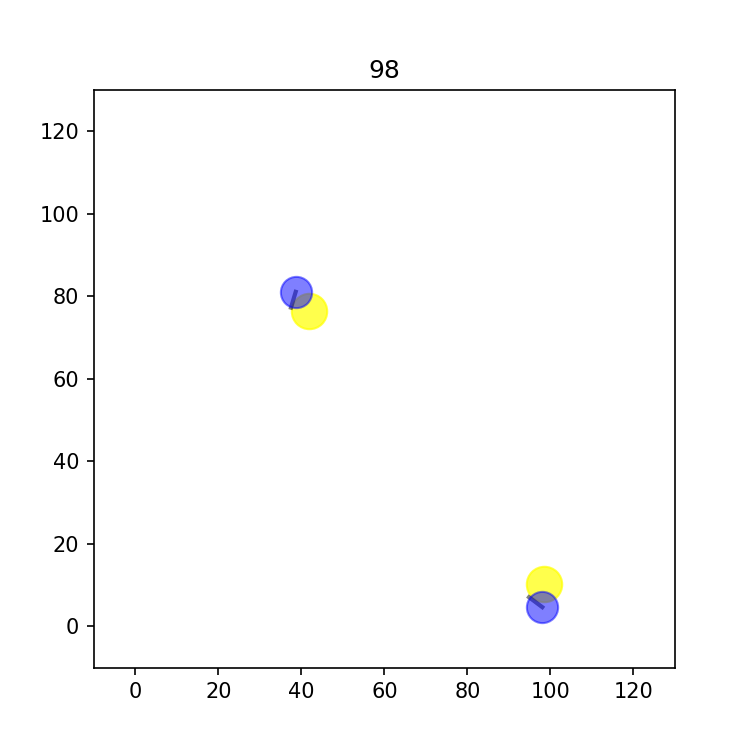

In [126]:
%matplotlib notebook

agent_nr = 2  # number of agents
light_nr = 2  # max number of light sources
update_gain = 1 # (similar to the learning rate in the gradient descent scheme)
iterations = 100

fig = plt.figure(figsize=(5, 5))
ax = fig.gca()
plt.ion()
plt.show(block=False)
x_agent, VFE = braitenberg_free_energy(fig, ax, agent_nr, light_nr, update_gain, iterations)

## Plot vehicles trajectory and the free energy

<IPython.core.display.Javascript object>


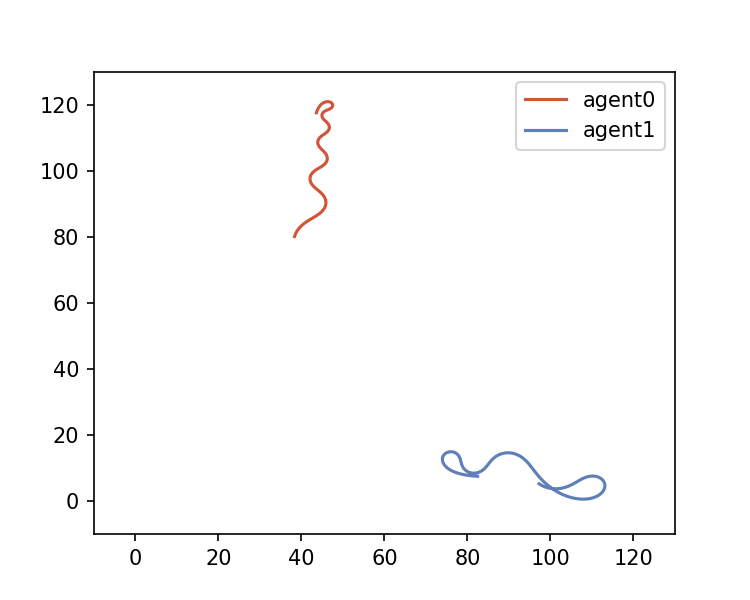

<IPython.core.display.Javascript object>


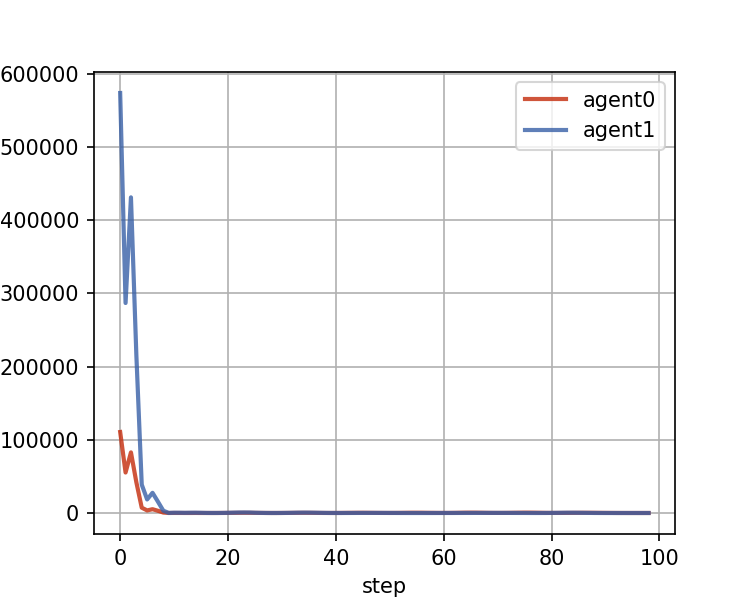

In [127]:
color= np.random.rand(3,agent_nr)

# plot trajectory 
fig = plt.figure(figsize=(5, 4))
ax = fig.gca()
ax.set_xlim(-10, 130)
ax.set_ylim(-10, 130)
for j in range(agent_nr):
    ax.plot(x_agent[:, 0, j], x_agent[:, 1, j], '-', color=color[:,j], alpha=0.8, label='agent'+str(j))
ax.legend()

# plot variational free energy (VFE)
fig = plt.figure(figsize=(5, 4))
ax = fig.gca()
plt.grid()
ax.set_xlabel('step')
ax.set_ylabel('VFE')
for j in range(agent_nr):
    ax.plot(VFE[:,j], color=color[:,j], linewidth=2, alpha=0.8, label='agent'+str(j))
ax.legend()